# Unisolar Projet
---

This project is based on the **UNISOLAR** open dataset containing information on solar energy production and weather in various locations of the La Trobe University, Victoria, Australia, stored in a time series format.

The main goal of this project will be to forecast energy production based on previous production and weather data with a horizon of 24 hours.

## Imports

---


In [1]:
import numpy as np
import pandas as pd
# import geopandas as pd
pd.options.display.max_rows = 50
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
plt.style.use('fast')

## Loading and arranging data

---


The project contains three datasets:
- Power generation for 42 sites split in 5 campus locations as a function of time.
- Details of the different sites (number and type of solar panel, location, etc.)
- Weather data for the different campus.

In [3]:
power_path = 'data/Solar_Energy_Generation.csv'
sites_path = 'data/Solar_Site_Details.csv'
weather_path = 'data/Weather_Data_reordered_all.csv'

In [4]:
df_power = pd.read_csv(power_path, parse_dates=['Timestamp'])

In [5]:
df_power['CampusKey'] = df_power['CampusKey'].astype('int8')
df_power['SiteKey'] = df_power['SiteKey'].astype('int8')
df_power['SolarGeneration'] = df_power['SolarGeneration'].astype('float32')

In [6]:
df_power.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2731946 entries, 0 to 2731945
Data columns (total 4 columns):
 #   Column           Dtype         
---  ------           -----         
 0   CampusKey        int8          
 1   SiteKey          int8          
 2   Timestamp        datetime64[ns]
 3   SolarGeneration  float32       
dtypes: datetime64[ns](1), float32(1), int8(2)
memory usage: 36.5 MB


In [7]:
df_sites = pd.read_csv(sites_path) 

In [8]:
df_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CampusKey         42 non-null     int64  
 1   SiteKey           42 non-null     int64  
 2   kWp               25 non-null     float64
 3   Number of panels  25 non-null     float64
 4   Panel             25 non-null     object 
 5   Inverter          25 non-null     object 
 6   Optimizers        23 non-null     object 
 7   Metric            25 non-null     object 
 8   lat               42 non-null     float64
 9   Lon               42 non-null     float64
dtypes: float64(4), int64(2), object(4)
memory usage: 3.4+ KB


In [9]:
df_weather = pd.read_csv(weather_path, index_col=['Timestamp', 'CampusKey'], parse_dates=['Timestamp'])

In [10]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 371769 entries, (Timestamp('2020-01-01 00:00:00'), 1) to (Timestamp('2022-04-23 22:00:00'), 5)
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ApparentTemperature  264656 non-null  float64
 1   AirTemperature       264656 non-null  float64
 2   DewPointTemperature  264656 non-null  float64
 3   RelativeHumidity     264656 non-null  float64
 4   WindSpeed            208879 non-null  float64
 5   WindDirection        208879 non-null  float64
dtypes: float64(6)
memory usage: 21.4 MB


# Exploratory Data Analysis

---

## Solar Energy Generation
---

In [11]:
df_power.head()

,CampusKey,SiteKey,Timestamp,SolarGeneration
0,2,1,2020-01-01 00:15:00,NaN
1,2,1,2020-01-01 00:30:00,NaN
2,2,1,2020-01-01 00:45:00,NaN
3,2,1,2020-01-01 01:00:00,NaN
4,2,1,2020-01-01 01:15:00,NaN


### Missing and duplicated data

In [12]:
print('Percent of missing date:\n', np.round(df_power.isna().sum()/len(df_power)*100), sep='')

Percent of missing date:
CampusKey           0.0
SiteKey             0.0
Timestamp           0.0
SolarGeneration    56.0
dtype: float64


More than 55% of the `SolarGeneration` data are missing.

In [13]:
print('Number of duplicated entries:', df_power.duplicated().sum())

Number of duplicated entries: 0


### Sites and campus

`SolarGeneration` data are recorded for 42 different sites, each located on different campus. 
We create a series `sites_in_campus` containing the site numbers belonging to each different campus.

In [14]:
sites_in_campus = df_power.groupby('CampusKey')['SiteKey'].unique()
print(sites_in_campus)

CampusKey
1    [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
2                                      [1, 2, 3, 4, 5]
3                         [6, 7, 8, 9, 10, 11, 12, 13]
4                                                 [41]
5                                                 [42]
Name: SiteKey, dtype: object


### Solar Generation distribution accross sites

Let's see how `SolarGeneration` compares between the different sites.

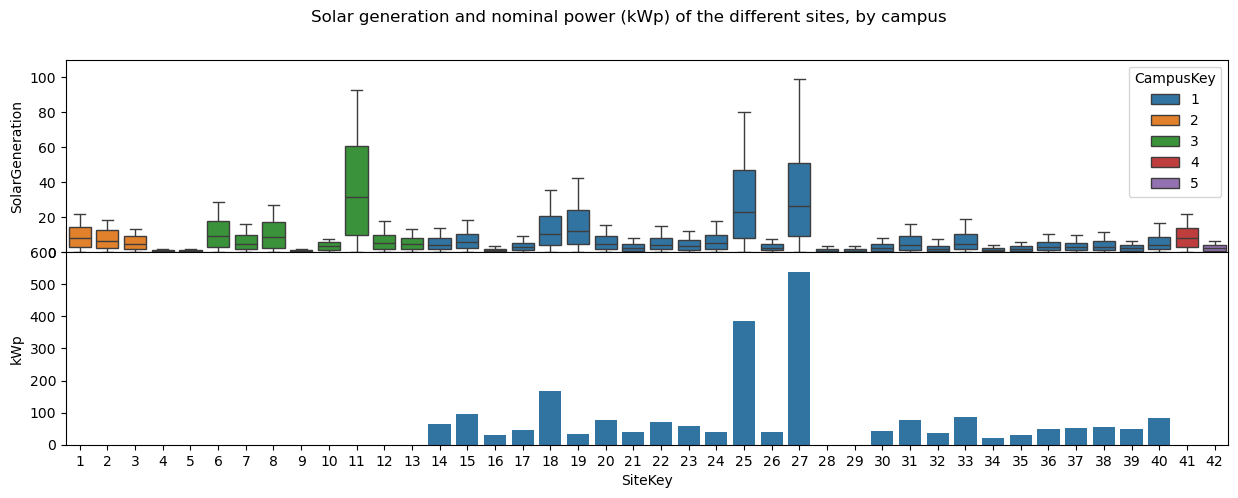

In [15]:
fig, axs = plt.subplots(2, 1, figsize = (15,5), sharex=True)
sns.boxplot(df_power, x='SiteKey', y='SolarGeneration', hue='CampusKey', palette='tab10', ax=axs[0])
sns.barplot(df_sites, x='SiteKey', y='kWp', hue='CampusKey', palette='tab10', ax=axs[1], legend=False)
fig.suptitle('Solar generation and nominal power (kWp) of the different sites, by campus')
fig.subplots_adjust(hspace=0)
axs[0].set_ylim(0, 110)
axs[1].set_ylim(0, 600);

The power generation varies significantly between sites. From the nominal power generation `kWp` (sum of nominal power of every panel in the site) for site 1 from the `df_sites` dataset, we see that different sites also have significantly different nominal power. This may account for most of the difference in power generation (but not all, as we can see when looking at sites number 18 and 19 for instance).


### Solar Generation series

From now on, it will be more convenient to work with the pivoted dataframe

In [16]:
df_power = df_power.pivot(index='Timestamp', columns='SiteKey', values='SolarGeneration')

In [17]:
df_power.head()

SiteKey,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can also look at the individual `SolarGeneration` time series for each campus.

In [18]:
def plot_sites_solar_time(df, sites, figure_height, title=None):
    """
    Plots the evolution of 'SolarGeneration' as a function of 'Timestamp' for all selected sites.
    """
    cmap = mpl.colormaps['viridis'].resampled(len(sites))
    fig, axs = plt.subplots(len(sites), figsize=(15, figure_height), sharex=True, squeeze=False, gridspec_kw={'hspace': 0})
    for i, site in enumerate(sites):
        axs[i,0].plot(df.index, df[site], c=cmap(i), label=f'Site {site}')
        axs[i,0].legend(frameon=True, loc='center left')
        axs[i,0].set(yticklabels=[])        # remove the ticks labels
        axs[i,0].tick_params(left=False)    # remove the ticks
    axs[-1,0].set_xlabel('Date')
    fig.text(0.1,0.5, "Solar Generation", ha="center", va="center", rotation=90)
    fig.suptitle(title)

For campus 1

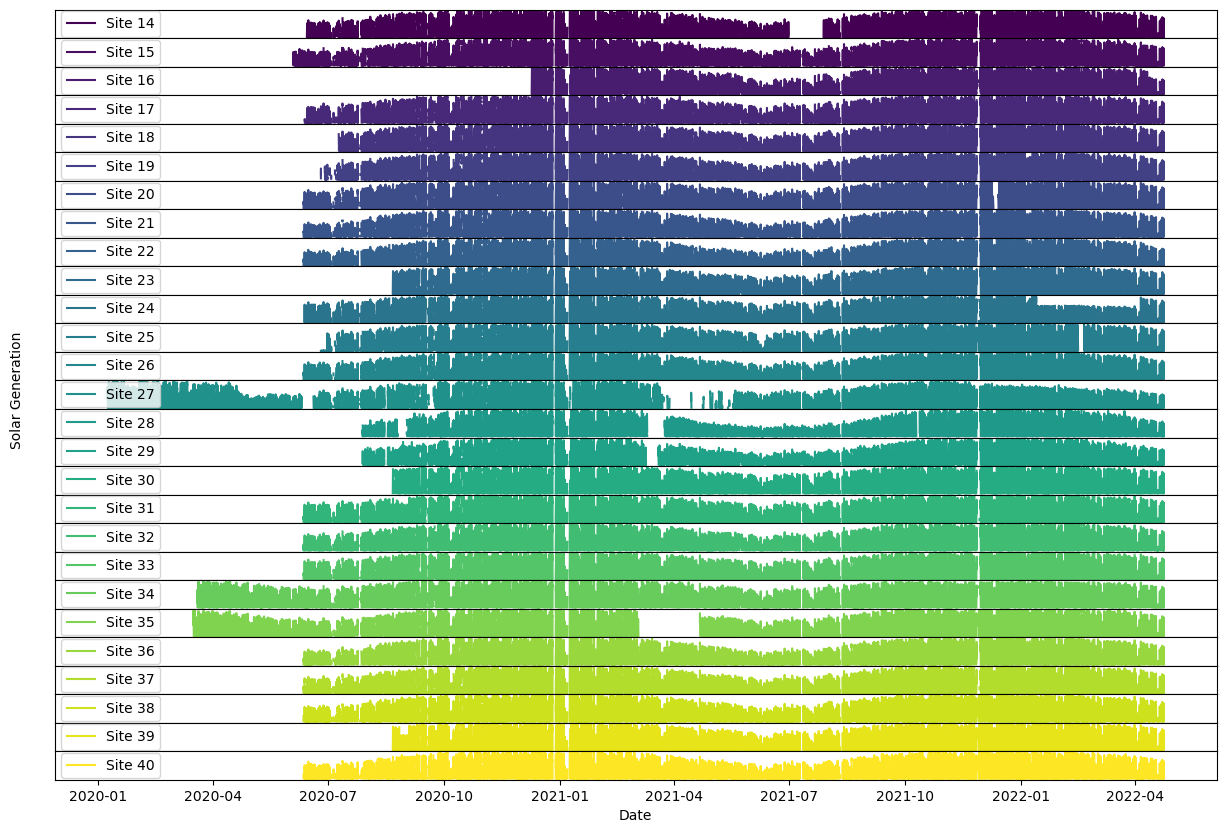

In [19]:
campus_number = 1
plot_sites_solar_time(df_power, sites_in_campus[campus_number], 10)

For campus 2

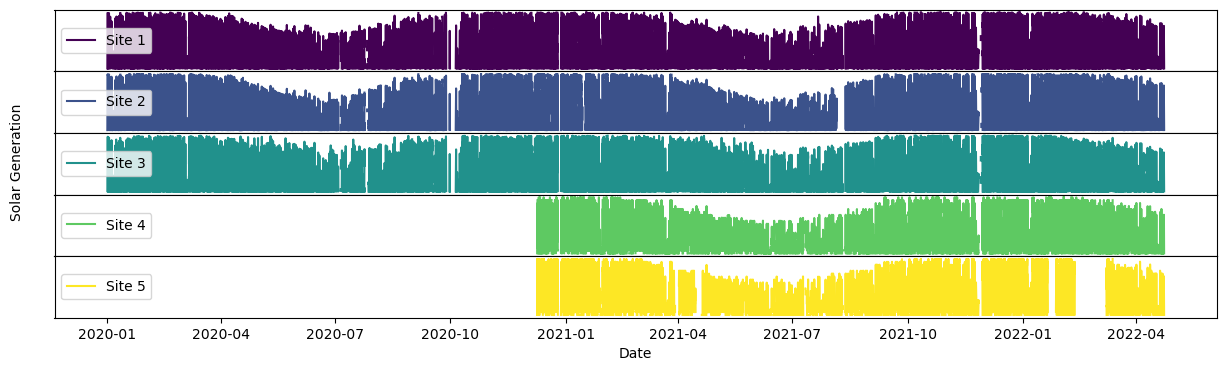

In [20]:
campus_number = 2
plot_sites_solar_time(df_power, sites_in_campus[campus_number], 4)

For campus 3

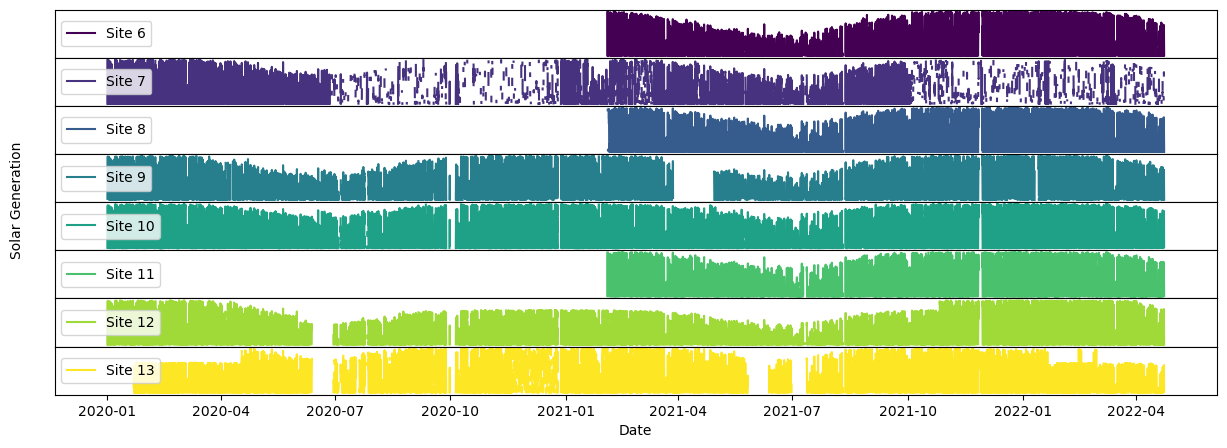

In [21]:
campus_number = 3
plot_sites_solar_time(df_power, sites_in_campus[campus_number], 5)

For campus 4

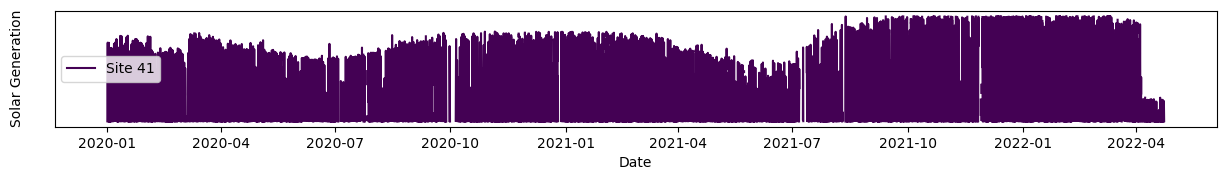

In [22]:
campus_number = 4
plot_sites_solar_time(df_power, sites_in_campus[campus_number], 1.5)

And campus 5

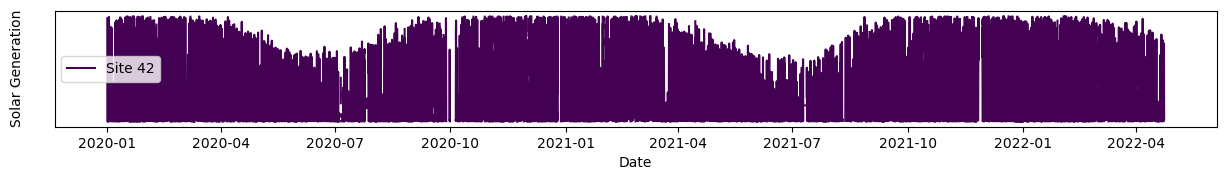

In [23]:
campus_number = 5
plot_sites_solar_time(df_power, sites_in_campus[campus_number], 1.5)

We can make three observation after looking at these five plots:
- Origin of missing data. It seems that some sites were deployed later than others, resulting in missing data for extended periods of time. We also observe smaller intervals without data that are sometimes shared between different sites and may be due to technical issues.
- There seems to be a substansial correlation between `SolarGeneration` of the different sites belonging to the same campus. Asides from missing data, sites plots for a given campus look close to identical in relative units.
- The `SolarGeneration` from the different campus are similar in terms of seasonality, be we observed difference, for instance in the location of the minimum power generation.

### Solar Generation correlation

We can check the correlation `SolarGeneration` between sites of a given campus.
Campus 2 and 3 have a site numbers small enough so we can plot correlation heatmaps.

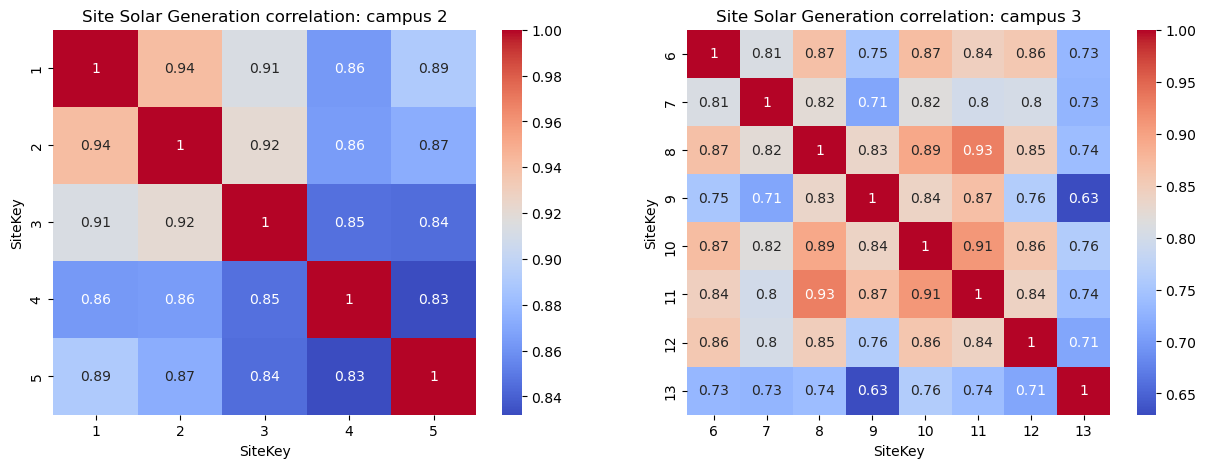

In [24]:
fig,axs = plt.subplots(1, 2, figsize=(15, 5))
for i, campus in enumerate([2, 3]):
    sns.heatmap(
        df_power[sites_in_campus[campus]].corr(method='kendall'),
        annot=True, cmap='coolwarm', ax=axs[i]
    )
    axs[i].set_title(f'Site Solar Generation correlation: campus {campus}');

The number of sites in campus 1 is to large to plot a heatmap, but we can find the lowest coefficient of correlation for all sites in campus 1:

Pivoting the Dataframe will be more convenient going forward.

In [25]:
print('Lowest site Solar Generationcorrelation coefficient for campus 1:',
       np.round(df_power[sites_in_campus[1]].corr().mean(axis=None)
                ,2
        )
)

Lowest site Solar Generationcorrelation coefficient for campus 1: 0.97


Campus 4 and 5 only have one site each.

Overal, the correlation coefficients for `SolarGeneration` between sites for each group is typically above 0.8. We will assume that each site is representative of its whole campus. To simplify our forecasting task, we will pick one site per campus. To decide which site to pick as a representative site, we will take a closer look at the missing data.

### Missing values

For each campus, we will use the site which the fewest missing values.

In [26]:
df_power[sites_in_campus[1]].isna().sum().sort_values().head(5)

SiteKey
27    44857
34    49632
15    50459
35    50774
24    50817
dtype: int64

Site 27 has fewer missing entries because its record starts earlier, but it has several large gap with no data. We will pick site 34 instead.

In [27]:
df_power[sites_in_campus[2]].isna().sum().sort_values().head()

SiteKey
1    42434
2    43242
3    43369
4    60530
5    62038
dtype: int64

In [28]:
df_power[sites_in_campus[3]].isna().sum().sort_values().head()

SiteKey
10    43559
12    43919
13    48377
9     49013
11    59678
dtype: int64

Sites number 27, 1, 10, 41, 42 are selected as representative of campus 1, 2, 3, 4 and 5, respectively.

In [29]:
selected_sites = [34, 1, 10, 41, 42]

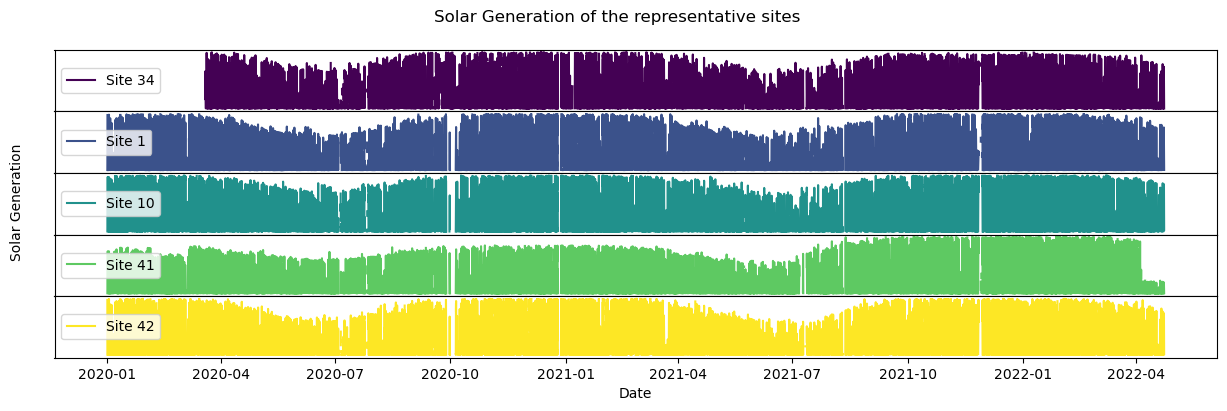

In [30]:
plot_sites_solar_time(df_power, selected_sites, 4, 'Solar Generation of the representative sites')

Looking at a smaller time window, we observe that the majority of missing data are between solar generation period, e.i. at night. There are also missing data during the day, but they are far less common and sometimes shared betweend sites .

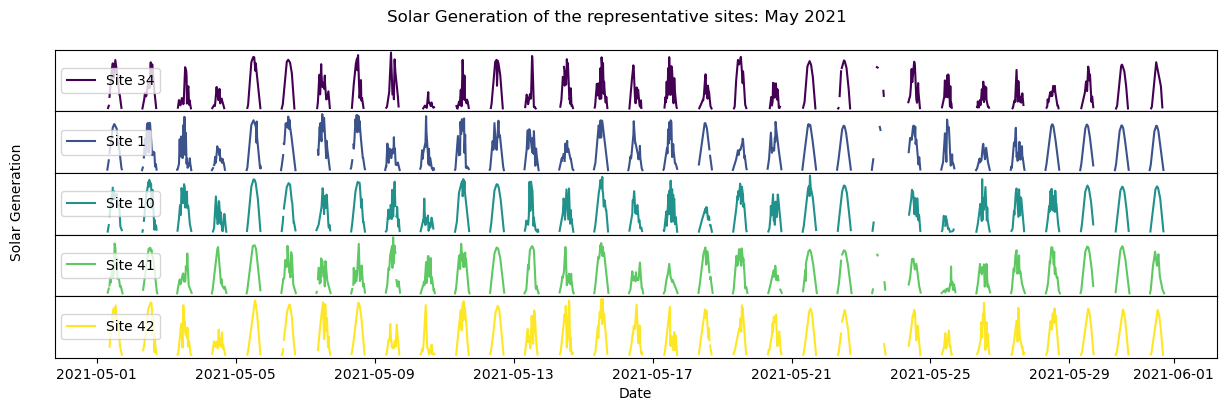

In [31]:
plot_sites_solar_time(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')], selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

Assuming the systems return `Nan` when `SolarGeneration` is smaller than a threshold power, it is possible that some daytime missing values are due to weather events leading the power generation to drop close to zer. Therefore it is safest to fill missing values with `0`.

In [32]:
df_power = df_power.fillna(0)

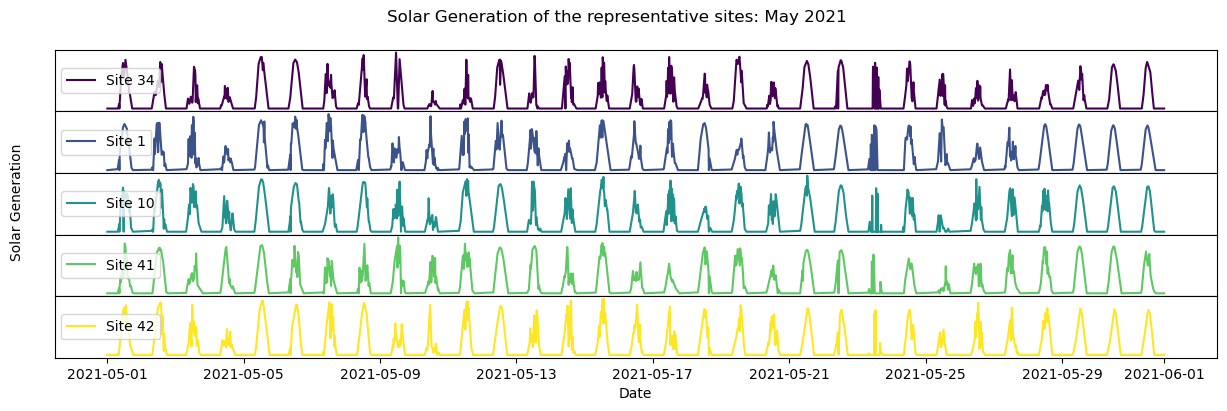

In [33]:
plot_sites_solar_time(df_power.loc[pd.Timestamp('2021-05'):pd.Timestamp('2021-06')], selected_sites, 4, 'Solar Generation of the representative sites: May 2021')

In [34]:
df_power.index.diff().unique()

TimedeltaIndex([              NaT, '0 days 00:15:00', '0 days 22:00:00',
                '1 days 06:30:00', '0 days 09:00:00', '0 days 01:15:00',
                '1 days 23:00:00', '0 days 19:00:00', '1 days 03:30:00',
                '0 days 01:30:00', '1 days 03:00:00', '1 days 15:45:00',
                '1 days 07:15:00'],
               dtype='timedelta64[ns]', name='Timestamp', freq=None)

In [35]:
len(df_power)

80007

In [36]:
min(df_power.index)

Timestamp('2020-01-01 00:15:00')

In [37]:
time_series_idx = pd.period_range(min(df_power.index), max(df_power.index),freq='15min')
df_power.reindex(time_series_idx, fill_value=0)

SiteKey,1,2,3,4,5,6,7,8,9,10,...,33,34,35,36,37,38,39,40,41,42
2020-01-01 00:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 00:45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-01 01:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-23 22:45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-23 23:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-23 23:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-04-23 23:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Solar site